## Example stock forecast from youTube video

[*********************100%***********************]  1 of 1 completed


Epoch 1/10
7/7 [==============================] - 3s 41ms/step - loss: 0.0852
Epoch 2/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0194
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0172
Epoch 4/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0113
Epoch 5/10
7/7 [==============================] - 0s 20ms/step - loss: 0.0093
Epoch 6/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0083
Epoch 7/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0077
Epoch 8/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 9/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0068
Epoch 10/10
4/4 [==============================] - 1s 9ms/step - loss: 0.0064
Test Loss: 0.006439354736357927
4/4 [==============================] - 1s 8ms/step


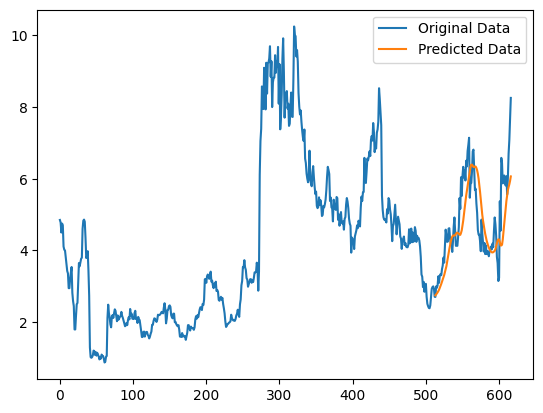

3/3 [==============================] - 0s 9ms/step


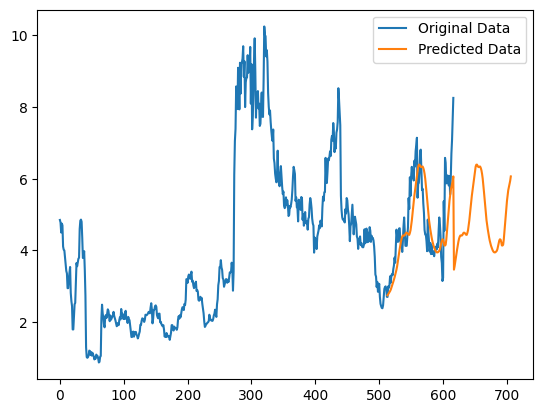

In [124]:
import yfinance as yf

stock_data_orig = yf.download('APLD', start='1980-01-01', end='2024-09-27')
stock_data = stock_data_orig

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

import numpy as np

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
	
time_step = 100
X, y = create_dataset(scaled_data, time_step)

train_size=0.8
X_train, X_test = X[:int(X.shape[0]*train_size)], X[int(X.shape[0]*train_size):]
y_train, y_test = y[:int(y.shape[0]*train_size)], y[int(y.shape[0]*train_size):]

from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=64))
model.add(Dense(units=64))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64)

test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

import matplotlib.pyplot as plt

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

new_predictions = model.predict(X_test[-90:])
new_predictions = scaler.inverse_transform(new_predictions)

predicted_data = np.append(predicted_data, new_predictions)
predicted_data[-20:]

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

## Refactor to use torch instead of tensorflow

In [104]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

Epoch [1/10], Loss: 0.0803
Epoch [2/10], Loss: 0.0630
Epoch [3/10], Loss: 0.0462
Epoch [4/10], Loss: 0.0419
Epoch [5/10], Loss: 0.0551
Epoch [6/10], Loss: 0.0361
Epoch [7/10], Loss: 0.0142
Epoch [8/10], Loss: 0.0216
Epoch [9/10], Loss: 0.0132
Epoch [10/10], Loss: 0.0098
Test Loss: 0.007221831940114498


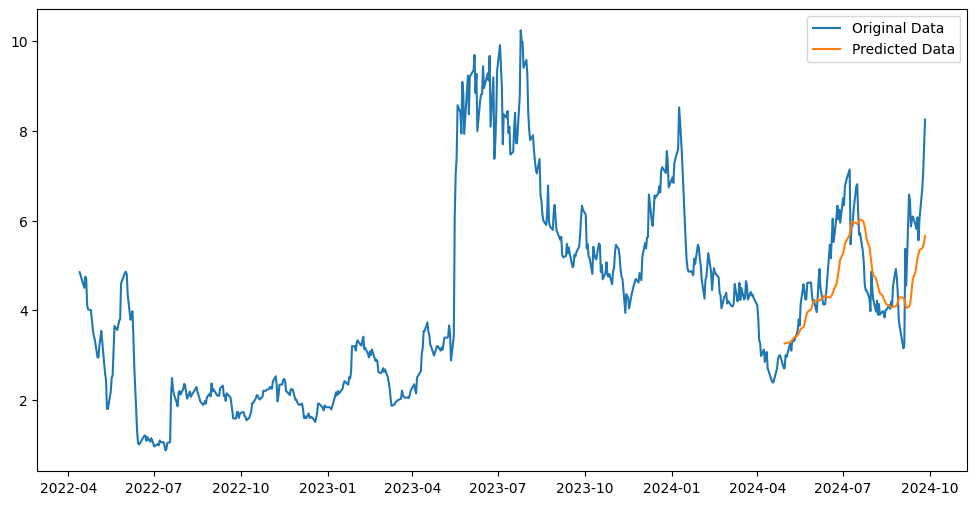

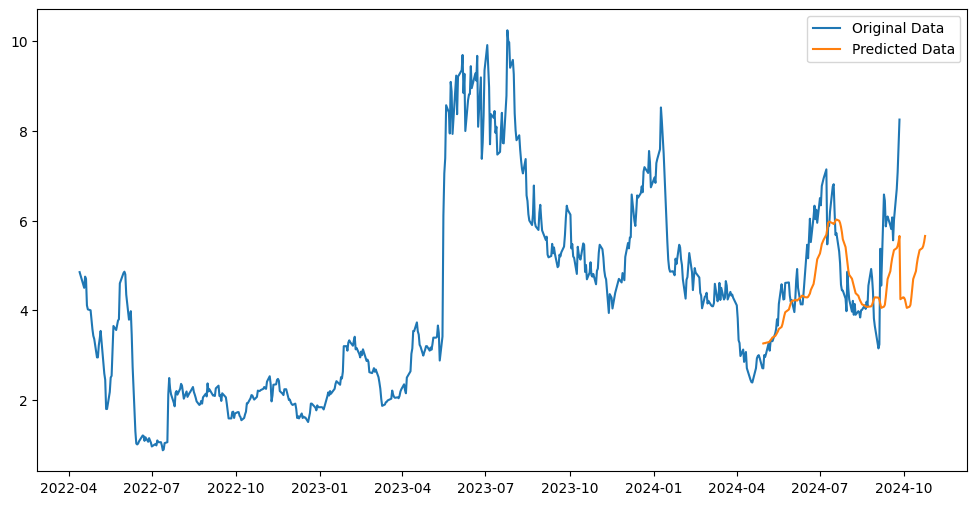

In [125]:
# Download stock data
stock_data = stock_data_orig

# Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Function to create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create the dataset
time_step = 100
X, y = create_dataset(scaled_data, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0]*train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().unsqueeze(2)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float().unsqueeze(2)
y_test = torch.from_numpy(y_test).float()

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the last output
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instantiate the model
model = LSTMModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions)

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Forecast the next 90 days using last 90 sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-20:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions)

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=20, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*20))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Refactor to use NASA-IBM climate model for wave propagation based on https://github.com/NASA-IMPACT/gravity-wave-finetuning/blob/main/gravity_wave_model.py

In [126]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Using device: cuda


h:\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0258
Epoch [2/10], Loss: 0.0037
Epoch [3/10], Loss: 0.0088
Epoch [4/10], Loss: 0.0026
Epoch [5/10], Loss: 0.0016
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0030
Epoch [8/10], Loss: 0.0038
Epoch [9/10], Loss: 0.0022
Epoch [10/10], Loss: 0.0007
Test Loss: 0.010570867918431759


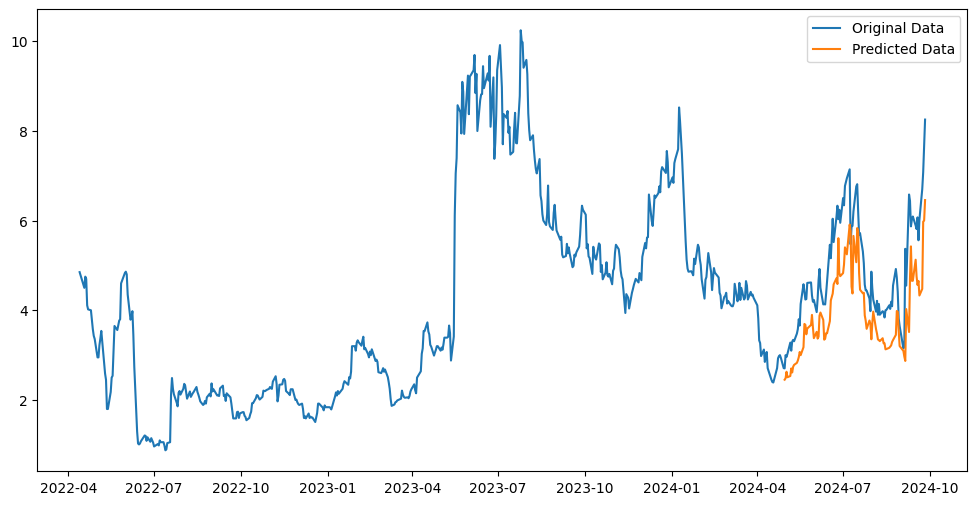

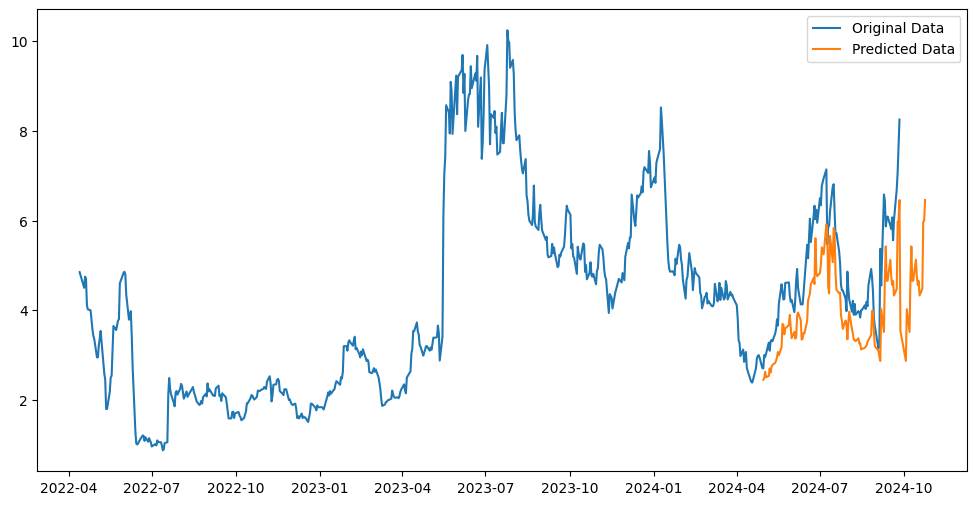

In [127]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

days_back = 100
days_ahead = 20

# Download stock data
stock_data = stock_data_orig

# Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Function to create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create the dataset
time_step = days_back
X, y = create_dataset(scaled_data, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0]*train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().unsqueeze(1).to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()

        # Updated up3 layer with output channels matching enc3
        self.up3 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 4,  # out_channels (256)
            kernel_size=2,
            stride=2,
            output_padding=1
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 8, hidden_channels * 4, kernel_size=3, padding=1),  # Input channels: 512
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose1d(
            hidden_channels * 4,  # in_channels (256)
            hidden_channels * 2,  # out_channels (128)
            kernel_size=2,
            stride=2
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1),  # Input channels: 256
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose1d(
            hidden_channels * 2,  # in_channels (128)
            hidden_channels,      # out_channels (64)
            kernel_size=2,
            stride=2
        )

        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1),  # Input channels: 128
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv1d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, enc1, enc2, enc3, bottleneck):
        up3 = self.up3(bottleneck)  # Output channels: 256
        dec3 = torch.cat((up3, enc3), dim=1)  # Channels: 256 + 256 = 512
        dec3 = self.decoder3(dec3)  # Output channels: 256

        up2 = self.up2(dec3)  # Output channels: 128
        dec2 = torch.cat((up2, enc2), dim=1)  # Channels: 128 + 128 = 256
        dec2 = self.decoder2(dec2)  # Output channels: 128

        up1 = self.up1(dec2)  # Output channels: 64
        dec1 = torch.cat((up1, enc1), dim=1)  # Channels: 64 + 64 = 128
        dec1 = self.decoder1(dec1)  # Output channels: 64

        output = self.final_conv(dec1)
        return output



# Define the Transformer Bottleneck
class TransformerBottleneck(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, seq_len)
        # Need to permute to (seq_len, batch_size, channels)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        # Permute back to (batch_size, channels, seq_len)
        x = x.permute(1, 2, 0)
        return x

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # Assuming output is of shape (batch_size, out_channels, seq_len)
        # For regression, we can take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=1, hidden_channels=64, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Forecast the next days ahead using last days ahead sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-days_ahead:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.cpu().detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Use feature engineering

In [128]:
def get_rsi_timeseries(prices, n=1):
    deltas = (prices - prices.shift(1)).fillna(0)

    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))  # Fix is here
        else:
            rsi_series.iloc[i] = 100  # Fix is here
        i += 1

    return rsi_series
    
def tr(data):
    data['previous_close'] = data['Close'].shift(1)
    data['high-low'] = abs(data['High'] - data['Low'])
    data['high-pc'] = abs(data['High'] - data['previous_close'])
    data['low-pc'] = abs(data['Low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr

def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
    
def supertrend(df, period=7, atr_multiplier=2.5):
    hl2 = (df['High'] + df['Low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = 1

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 1
        elif df['Close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = 0
        else:
            df.loc[df.index[current], 'in_uptrend'] = df.loc[df.index[previous], 'in_uptrend']

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df.loc[df.index[previous], 'lowerband']

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df.loc[df.index[previous], 'upperband']
        
    return df
    
def calculate_technical_indicators(df):
    # Bollinger Bands
    df['20_day_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_day_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_day_SMA'] + (df['20_day_STD'] * 2)
    df['Lower_Band'] = df['20_day_SMA'] - (df['20_day_STD'] * 2)
    df['Bollinger_Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # MACD
    df['26_ema'] = df['Adj Close'].ewm(span=26).mean()
    df['12_ema'] = df['Adj Close'].ewm(span=12).mean()
    df['MACD'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    
    # Stochastic Oscillator
    df['14_High'] = df['High'].rolling(14).max()
    df['14_Low'] = df['Low'].rolling(14).min()
    df['%K'] = 100*((df['Close'] - df['14_Low']) / (df['14_High'] - df['14_Low']) )
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Williams %R
    df['Williams_%R'] = -100 * (df['14_High'] - df['Close']) / (df['14_High'] - df['14_Low'])
    
    # Accumulation/Distribution Line
    df['CLV'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    df['CLV'] = df['CLV'].fillna(0)  # NaN and inf values will be replaced with 0
    df['ADL'] = (df['CLV'] * df['Volume']).cumsum()
    
    # On Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()).fillna(0) * df['Volume']).cumsum()
    
    # Historical Volatility
    df['Log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['Historical_Volatility'] = df['Log_ret'].rolling(window=252).std() * np.sqrt(252)
    
    # VWAP
    df['Cumulative_Volume_Price'] = (df['Volume'] * df['Adj Close']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Volume_Price'] / df['Cumulative_Volume']
    df['smaVWAP'] = df['VWAP'].rolling(window=10,min_periods=1).mean()
   
    return df

In [129]:
# Download stock data
stock_data = stock_data_orig

# Calculate the features
def calculate_features(df):
    df['hlc3'] = (df['Close'] + df['High'] + df['Low']) / 3.0
    df['sma3'] = df['hlc3'].rolling(window=3,min_periods=1).mean()
    df['ema1'] = df['hlc3'].ewm(span=7).mean()
    df['ema2'] = df['hlc3'].ewm(span=16).mean()
    df['ema3'] =  df['hlc3'].ewm(span=25).mean()
    df['MACD'] = (df['ema1'] - df['ema3'])
    df['rsi'] = get_rsi_timeseries(df['Adj Close'], 12)
    df['SMArsi'] = df['rsi'].rolling(window=15,min_periods=1).mean()
    df['drsi'] = df['rsi'] - df['SMArsi']
    df['dSMArsi'] = df['SMArsi'].shift(1).fillna(0).astype(float) - df['SMArsi']
    df['smah4'] = df['High'].rolling(window=4,min_periods=1).mean()
    df['smal4'] = df['Low'].rolling(window=4,min_periods=1).mean()
    df['dsmah4'] = df['Adj Close'] - df['smah4']
    
    # Create Bollinger Bands
    df['sma10'] = df['Adj Close'].rolling(window=10,min_periods=1).mean()
    
    # tech indicators
    df = calculate_technical_indicators(df)
    
    df = supertrend(df)
    df['kst'] = df['sma3'] - df['ema1'] + df['sma3'] - df['ema2'] + df['sma3'] - df['ema3']
    df['SMAkst'] = df['kst'].rolling(window=15,min_periods=1).mean()
    df['dkst'] = df['SMAkst'] - df['kst']
    df['wema1'] = df['hlc3'] - df['ema1']
    df['wema2'] = df['hlc3'] - df['ema2']
    df['wema3'] = df['hlc3'] - df['ema3']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    return df

In [130]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-13,4.70,4.900,4.500,4.85,4.85,3116200
2022-04-14,4.70,4.900,4.580,4.78,4.78,372000
2022-04-18,4.60,4.668,4.460,4.50,4.50,145100
2022-04-19,4.50,4.800,4.450,4.75,4.75,319900
2022-04-20,4.75,4.770,4.600,4.70,4.70,211900
...,...,...,...,...,...,...
2024-09-20,5.56,6.090,5.510,6.02,6.02,17700800
2024-09-23,6.13,6.870,6.025,6.70,6.70,15381500
2024-09-24,6.72,7.200,6.470,7.08,7.08,15410200


In [131]:
stock_data = calculate_features(stock_data)

# List of features (including 'Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "VWAP", "smaVWAP", "SMAkst"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

In [132]:
# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

# Create the dataset
time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors and reshape
X_train = torch.from_numpy(X_train).float().to(device)  # No need to unsqueeze as we have multi-feature input
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

# (The Decoder and Transformer bottleneck remain the same)

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()

# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=64, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (same as before)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

h:\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0366
Epoch [2/10], Loss: 0.0041
Epoch [3/10], Loss: 0.0033
Epoch [4/10], Loss: 0.0020
Epoch [5/10], Loss: 0.0015
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0027
Epoch [8/10], Loss: 0.0039
Epoch [9/10], Loss: 0.0016
Epoch [10/10], Loss: 0.0045


Test Loss: 0.0025782431475818157


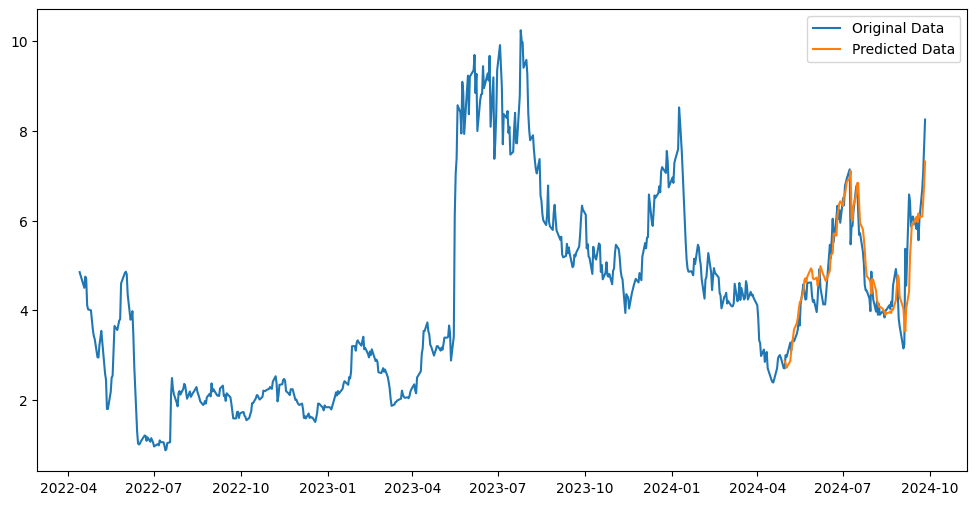

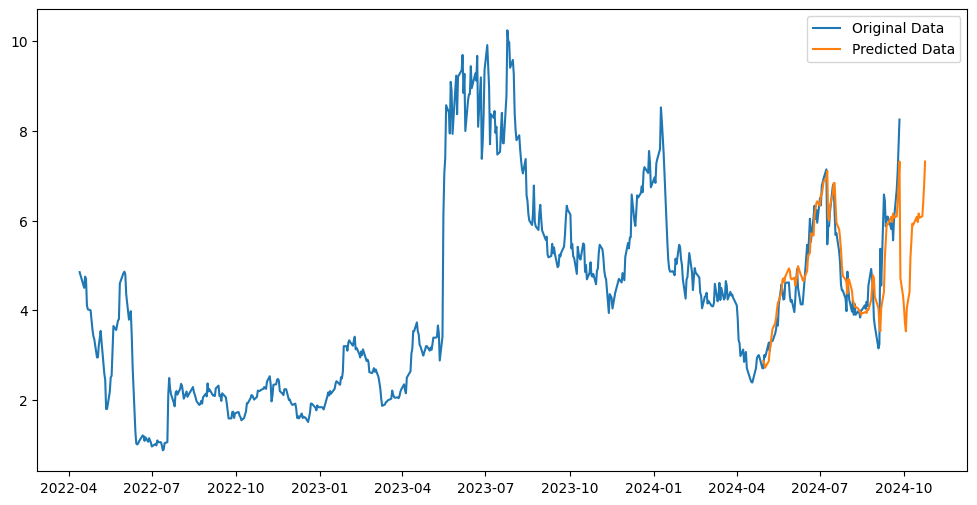

In [133]:
# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

days_ahead = 20
# Forecast the next days ahead using last days ahead sequences from X_test
with torch.no_grad():
    future_inputs = X_test[-days_ahead:]
    future_predictions = model(future_inputs)
    future_predictions = future_predictions.cpu().detach().numpy()
    future_predictions_scaled = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled.reshape(-1)))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Now lets add a persistant homology feature from topological data analysis

In [134]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [135]:
# Download stock data
stock_data = yf.download('APLD', start='1980-01-01', end='2024-09-27')

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "VWAP", "smaVWAP", "SMAkst"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [136]:
# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

In [137]:
# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

# Define your time_step (days_back) if not defined
days_back = 60  # Adjust as needed
time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split into training and testing sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train, X_test = X[:train_size_int], X[train_size_int:]
y_train, y_test = y[:train_size_int], y[train_size_int:]

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [138]:
# ------------------------ #
# Part 4: Define Model (Assuming Encoder, Decoder, Transformer are defined)
# ------------------------ #
# Update Encoder and Decoder to handle multiple features
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels * 4, hidden_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)
        return enc1, enc2, enc3, enc3_pooled

# (The Decoder and Transformer bottleneck remain the same)

# Define the complete model
class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(UNetWithTransformer, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels)
        self.transformer = TransformerBottleneck(input_dim=hidden_channels * 4, nhead=8, num_layers=4, dim_feedforward=512)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x):
        # Permute x to (batch_size, num_features, time_steps) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Pass through the encoder, transformer, and decoder
        enc1, enc2, enc3, bottleneck = self.encoder(x)
        bottleneck = self.transformer(bottleneck)
        output = self.decoder(enc1, enc2, enc3, bottleneck)
        # For regression, take the last time step
        output = output[:, :, -1]
        return output.squeeze()


In [139]:
# Instantiate the model
model = UNetWithTransformer(in_channels=len(FEATURE_COLUMNS), hidden_channels=64, out_channels=1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------ #
# Part 5: Training Loop
# ------------------------ #

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

h:\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 0.0168
Epoch [2/10], Loss: 0.0060
Epoch [3/10], Loss: 0.0052
Epoch [4/10], Loss: 0.0016
Epoch [5/10], Loss: 0.0031
Epoch [6/10], Loss: 0.0027
Epoch [7/10], Loss: 0.0019
Epoch [8/10], Loss: 0.0014
Epoch [9/10], Loss: 0.0015
Epoch [10/10], Loss: 0.0015


Test Loss: 0.00359338172711432


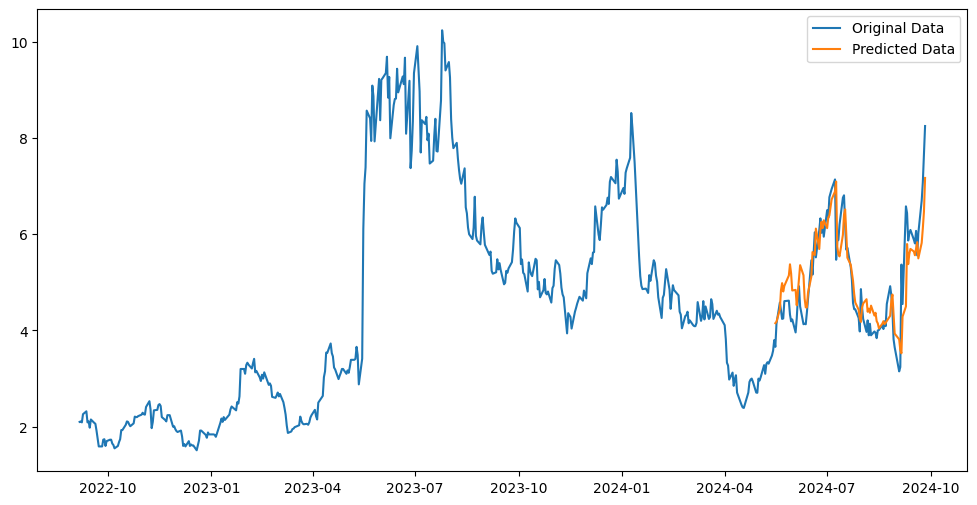

In [140]:
# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss:', test_loss.item())

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

In [141]:
# Define the number of days ahead you want to predict
days_ahead = 20  # Adjust as needed

# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence from your data
last_sequence = X_test[-1].cpu().numpy()  # Shape: (time_step, num_features)

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Prepare the new features for the next time step
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    
    # Update 'Adj Close' with the predicted normalized value
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For other features, either keep them constant or update if possible
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        elif feature in ['hlc3', 'ema1', 'ema2', 'ema3', 'rsi', 'VWAP', 'smaVWAP', 'SMAkst']:
            # You can attempt to update these features if you have formulas
            # For now, we'll keep them the same as the last known values
            new_features[0][idx] = last_sequence[-1][idx]
        elif feature in ['entropy_H0', 'entropy_H1']:
            # Keep TDA features constant
            new_features[0][idx] = last_sequence[-1][idx]
        else:
            # For any other features, keep the last known value
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))


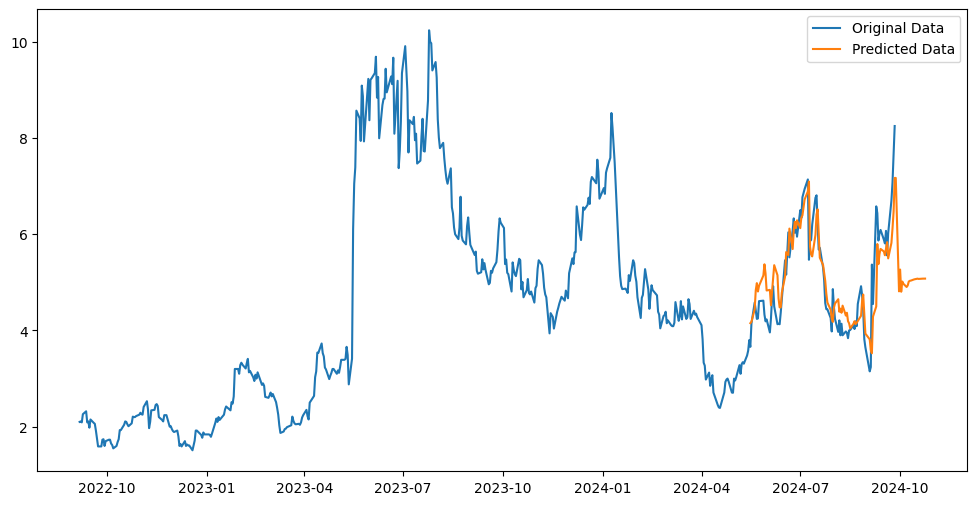

In [142]:
# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()

## Lets enable the model to iterate until it doesn't improve after 20 iterations instead of specifying the number of epochs.  Keep the best model.

In [153]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf

from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


In [154]:
stock_data_orig = yf.download('APLD', start='1980-01-01', end='2024-09-27')
stock_data = stock_data_orig

stock_data = calculate_features(stock_data)  # Assuming you have a function to calculate other features

# List of features (including 'Adj Close')
FEATURE_COLUMNS = ["Adj Close", "hlc3", "ema1", "ema2", "ema3", "rsi", "VWAP", "smaVWAP", "SMAkst"]

# Drop any rows with NaN values (optional depending on your data)
stock_data.dropna(inplace=True)

# ------------------------ #
# Part 1: TDA Feature Engineering
# ------------------------ #

# Prepare the time series windows for TDA feature extraction
adj_close = stock_data['Adj Close'].values

# Parameters for windowing
window_size = 100  # Adjust as needed
window_stride = 1  # Adjust as needed
# Define the number of days ahead you want to predict
days_ahead = 20  # Adjust as needed

def create_time_series_windows(data, window_size, stride):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
        indices.append(i)
    return np.array(windows), indices

time_series_windows, window_indices = create_time_series_windows(adj_close, window_size, window_stride)

# Set up the TDA pipeline
embedding_dimension = 30  # Adjust as needed
embedding_time_delay = 1  # Adjust as needed

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=1)  # Since our windows are already sampled

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]

topological_transformer = Pipeline(steps)

# Apply the pipeline to time_series_windows
features = topological_transformer.fit_transform(time_series_windows)

# Create DataFrame with features and timestamps
timestamps = stock_data.index.values

# Align features with corresponding timestamps
feature_timestamps = [timestamps[i + window_size - 1] for i in window_indices]

features_df = pd.DataFrame(features, index=feature_timestamps, columns=['entropy_H0', 'entropy_H1'])

# Merge features_df into stock_data
stock_data = stock_data.merge(features_df, how='left', left_index=True, right_index=True)

# Drop NaN values resulting from the merging
stock_data.dropna(inplace=True)

# Update FEATURE_COLUMNS to include the new features
FEATURE_COLUMNS.extend(['entropy_H0', 'entropy_H1'])

[*********************100%***********************]  1 of 1 completed


In [155]:
# ------------------------ #
# Part 2: Scaling Features
# ------------------------ #

# Scale each feature individually
scalers = {}
for feature in FEATURE_COLUMNS:
    scalers[feature] = MinMaxScaler(feature_range=(0.05, 0.95))
    stock_data[feature] = scalers[feature].fit_transform(stock_data[feature].values.reshape(-1, 1))

# ------------------------ #
# Part 3: Prepare Dataset and Model Training
# ------------------------ #

# Create the dataset with multiple features
def create_multifeature_dataset(data, features, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[features].values[i:(i + time_step)])  # Multi-feature input
        y.append(data['Adj Close'].values[i + time_step])       # Predicting close price
    return np.array(X), np.array(y)

# Define your time_step (days_back) if not defined
days_back = 60  # Adjust as needed
time_step = days_back
X, y = create_multifeature_dataset(stock_data, FEATURE_COLUMNS, time_step)

# Split data into training, validation, and test sets
train_size = 0.8
train_size_int = int(X.shape[0] * train_size)
X_train_full, X_test = X[:train_size_int], X[train_size_int:]
y_train_full, y_test = y[:train_size_int], y[train_size_int:]

validation_split = 0.1
val_size_int = int(X_train_full.shape[0] * validation_split)
X_train, X_val = X_train_full[:-val_size_int], X_train_full[-val_size_int:]
y_train, y_val = y_train_full[:-val_size_int], y_train_full[-val_size_int:]

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_val = torch.from_numpy(X_val).float().to(device)
y_val = torch.from_numpy(y_val).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

epoch = 0
max_epochs = 10000

while not early_stop and epoch < max_epochs:
    epoch += 1
    model.train()
    epoch_train_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f'Epoch [{epoch}], Training Loss: {epoch_train_loss:.6f}, Validation Loss: {val_loss:.6f}')
    
    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            early_stop = True

# Load the best model weights
model.load_state_dict(best_model_wts)

print(f'Total epochs trained: {epoch}')

# Evaluate test loss
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()
print('Test Loss:', test_loss)

Epoch [1], Training Loss: 0.001458, Validation Loss: 0.004118
Epoch [2], Training Loss: 0.001306, Validation Loss: 0.010139
Epoch [3], Training Loss: 0.001061, Validation Loss: 0.003770
Epoch [4], Training Loss: 0.000944, Validation Loss: 0.005709
Epoch [5], Training Loss: 0.000776, Validation Loss: 0.004267
Epoch [6], Training Loss: 0.000715, Validation Loss: 0.002718
Epoch [7], Training Loss: 0.000607, Validation Loss: 0.001521
Epoch [8], Training Loss: 0.000559, Validation Loss: 0.002203
Epoch [9], Training Loss: 0.000530, Validation Loss: 0.001643
Epoch [10], Training Loss: 0.000672, Validation Loss: 0.002904
Epoch [11], Training Loss: 0.000707, Validation Loss: 0.003146
Epoch [12], Training Loss: 0.000629, Validation Loss: 0.003363
Epoch [13], Training Loss: 0.000633, Validation Loss: 0.004513
Epoch [14], Training Loss: 0.000521, Validation Loss: 0.003015
Epoch [15], Training Loss: 0.000625, Validation Loss: 0.003333
Epoch [16], Training Loss: 0.000915, Validation Loss: 0.003525
E

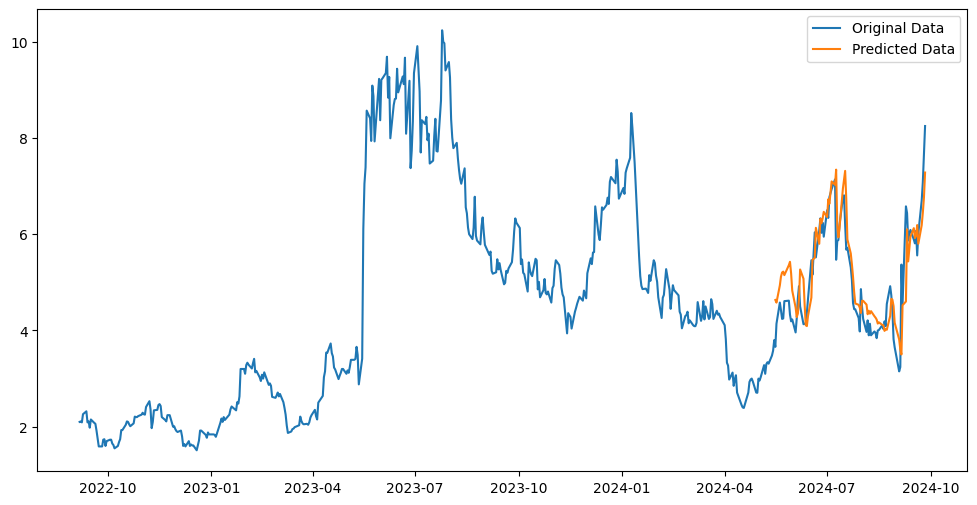

In [156]:
# ------------------------ #
# Part 6: Evaluation and Forecasting
# ------------------------ #

# Make predictions on X_test
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = test_predictions.cpu().detach().numpy()
    test_predictions_scaled = scalers['Adj Close'].inverse_transform(test_predictions.reshape(-1, 1))

# Prepare data for plotting
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(test_predictions_scaled):] = test_predictions_scaled.reshape(-1)

# Plot original data and predicted data
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, original_data, label='Original Data')
plt.plot(stock_data.index, predicted_data, label='Predicted Data')
plt.legend()
plt.show()

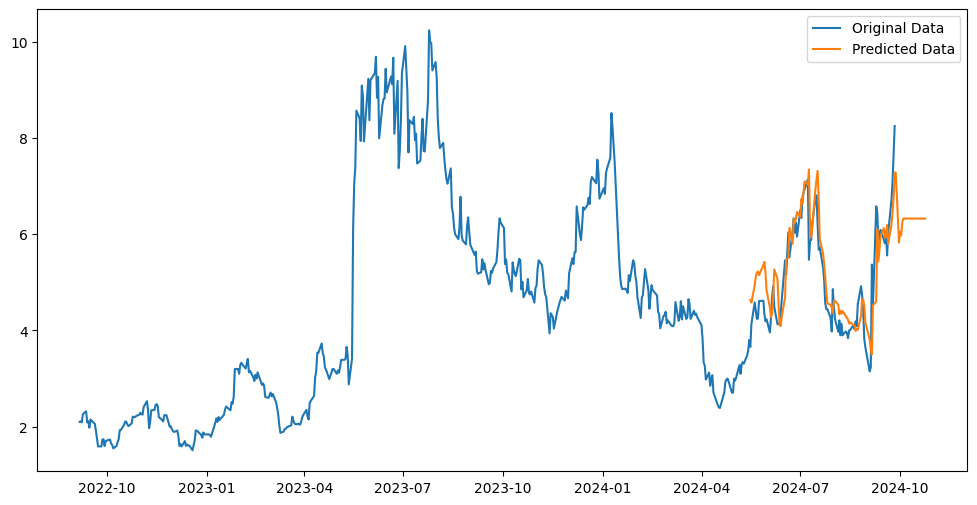

In [158]:


# Initialize a list to store future predictions
future_predictions_scaled = []

# Start with the last available input sequence from your data
last_sequence = X_test[-1].cpu().numpy()  # Shape: (time_step, num_features)

# Loop to predict each future day iteratively
for _ in range(days_ahead):
    # Convert last_sequence to tensor and move to device
    input_seq = torch.from_numpy(last_sequence).unsqueeze(0).float().to(device)  # Shape: (1, time_step, num_features)
    
    # Make prediction
    with torch.no_grad():
        pred = model(input_seq)
    
    # Ensure pred is a tensor of shape (1,)
    if pred.dim() == 0:
        pred = pred.unsqueeze(0)
    
    # Convert prediction to NumPy array
    pred_np = pred.cpu().numpy()  # Shape: (1,)
    
    # Inverse transform the prediction
    pred_scaled = scalers['Adj Close'].inverse_transform(pred_np.reshape(-1, 1))[0][0]
    
    # Append prediction to the list
    future_predictions_scaled.append(pred_scaled)
    
    # Prepare the new features for the next time step
    new_features = np.zeros((1, len(FEATURE_COLUMNS)))
    
    # Update 'Adj Close' with the predicted normalized value
    pred_scaled_norm = scalers['Adj Close'].transform(pred_np.reshape(-1, 1))[0][0]
    new_features[0][FEATURE_COLUMNS.index('Adj Close')] = pred_scaled_norm
    
    # For other features, either keep them constant or update if possible
    for idx, feature in enumerate(FEATURE_COLUMNS):
        if feature == 'Adj Close':
            continue
        elif feature in ['hlc3', 'ema1', 'ema2', 'ema3', 'rsi', 'VWAP', 'smaVWAP', 'SMAkst']:
            # You can attempt to update these features if you have formulas
            # For now, we'll keep them the same as the last known values
            new_features[0][idx] = last_sequence[-1][idx]
        elif feature in ['entropy_H0', 'entropy_H1']:
            # Keep TDA features constant
            new_features[0][idx] = last_sequence[-1][idx]
        else:
            # For any other features, keep the last known value
            new_features[0][idx] = last_sequence[-1][idx]
    
    # Update last_sequence
    last_sequence = np.vstack((last_sequence[1:], new_features))

# Prepare data for plotting
# Extend dates for future predictions
future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=days_ahead, freq='B')
full_dates = stock_data.index.append(future_dates)

# Append future predictions to predicted_data
predicted_data_full = np.concatenate((predicted_data, future_predictions_scaled))
original_data_full = np.concatenate((original_data, [np.nan]*days_ahead))

# Plot the data including future predictions
plt.figure(figsize=(12,6))
plt.plot(full_dates, original_data_full, label='Original Data')
plt.plot(full_dates, predicted_data_full, label='Predicted Data')
plt.legend()
plt.show()
